In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
GOLD_DATA_PATH = "/data/group1/z40436a/ME/URL_Citation_Classification_Intermediate/data/all_data.csv"
csv_dataset = pd.read_csv(GOLD_DATA_PATH, index_col=0)
model_names = ["meta-llama/Llama-3.1-8B-Instruct", "google/gemma-2-9b-it", "mistralai/Mistral-Nemo-Instruct-2407"]

In [4]:
def pred_type_and_func(LLM_responses: json) -> tuple[list, list]:
    type_preds = []
    func_preds = []

    for each_response in LLM_responses:
        # print(each_response[-1]['generated_text'])
        completion = each_response[-1]['generated_text'][-1]
        if completion['role'] == 'assistant':
            try:
                # print("TYPE:", completion['content'].split("TYPE: ")[1].split()[0])
                type_preds.append(completion['content'].split("TYPE: ")[1].split()[0])
            except:
                # print("format error")
                type_preds.append("FormatError")
            try:
                # print("FUNCTION:", completion['content'].split("FUNCTION: ")[1].split()[0])
                func_preds.append(completion['content'].split("FUNCTION: ")[1].split()[0])
            except:
                # print("format error")
                func_preds.append("FormatError")

    return type_preds, func_preds

In [5]:
def evaluation_metrics(gold:list[str], pred:list[str], eval_mode:str) -> dict:
    if eval_mode == "type":
        label_set = ["Tool", "Code", "Dataset", "Knowledge", "DataSource", "Document", "Paper", "Media", "Website", "Mixed"]
    elif eval_mode == "func":
        label_set = ["Use", "Produce", "Compare", "Extend", "Introduce", "Other"]
    else:
        print("set apprepriate eval_mode")

    acc = accuracy_score(gold, pred)
    pre = precision_score(gold, pred, labels=label_set, average="macro", zero_division=0)
    rec = recall_score(gold, pred, average="macro", zero_division=0)
    if pre * rec == 0:
        f1 = 0
    else:
        f1 = 2 * pre * rec / (pre + rec)
    err_rate = pred.count('FormatError') / len(pred)

    return {"acc": acc, "pre":pre, "rec":rec, "f1":f1, "err": err_rate}

In [6]:
def ave_metrics_seed(metrics_lst:list[dict]) -> dict:
    """
    Parameters:
        dict_list (list): 

    Returns:
        dict: 
    """
    if not metrics_lst:
        return {}

    # 初期化
    result = {}
    num_dicts = len(metrics_lst)

    # キーごとに値を合計
    for d in metrics_lst:
        for key, value in d.items():
            result[key] = result.get(key, 0) + value

    # 平均を計算
    for key in result:
        result[key] /= num_dicts

    return result

In [7]:
def round_print(input_dict:dict, round_num:int=3):
    rounded_data = {key: round(value, round_num) for key, value in input_dict.items()}
    print(rounded_data)

In [8]:
show_types = []
show_funcs = []

In [9]:
lst_for_graph = []

In [10]:
for model_name in model_names:
    print(model_name)
    for icl_method in ["random", "bm25", "encoder"]:
        if icl_method == "bm25" or icl_method == "encoder":
            continue
        print(f"icl_method = {icl_method}")
        for k in range(1, 5+1):
            print(f"{str(k)}-shot")
            metrics_types_seeds = []
            metrics_funcs_seeds = []
            for seed in [111, 5374, 93279]:
                # print(seed)
                # create gold answer
                train_df, eval_df = train_test_split(csv_dataset, test_size = 0.1, random_state=int(seed))
                gold_types, gold_funcs = [], []
                for i, row in eval_df.iterrows():
                    gold_types.append(row['type'])
                    gold_funcs.append(row['function'].split("（")[0])

                # create pred answer
                pred_data_path = f"/data/group1/z40436a/ME/URL_Citation_Classification_Intermediate/result/output/{model_name}/{icl_method}/{str(seed)}_{str(k)}shot.json"
                with open(pred_data_path, 'r') as json_file:
                    LLM_responses = json.load(json_file)

                pred_types, pred_funcs = pred_type_and_func(LLM_responses)

                pred_types = [pred if pred in list(set(gold_types)) else "FormatError" for pred in pred_types]
                pred_funcs = [pred if pred in list(set(gold_funcs)) else "FormatError" for pred in pred_funcs]

                metrics_types_seeds.append(evaluation_metrics(gold_types, pred_types, "type"))
                metrics_funcs_seeds.append(evaluation_metrics(gold_funcs, pred_funcs, "func"))

            
            print("TYPE:", end="")
            round_print(ave_metrics_seed(metrics_types_seeds))
            show_types.append(ave_metrics_seed(metrics_types_seeds))
            print("FUNC:", end="")
            round_print(ave_metrics_seed(metrics_funcs_seeds))
            show_funcs.append(ave_metrics_seed(metrics_funcs_seeds))

meta-llama/Llama-3.1-8B-Instruct
icl_method = random
1-shot
TYPE:{'acc': 0.531, 'pre': 0.551, 'rec': 0.461, 'f1': 0.502, 'err': 0.002}
FUNC:{'acc': 0.426, 'pre': 0.247, 'rec': 0.214, 'f1': 0.229, 'err': 0.026}
2-shot
TYPE:{'acc': 0.516, 'pre': 0.535, 'rec': 0.43, 'f1': 0.476, 'err': 0.003}
FUNC:{'acc': 0.444, 'pre': 0.298, 'rec': 0.241, 'f1': 0.259, 'err': 0.022}
3-shot
TYPE:{'acc': 0.525, 'pre': 0.536, 'rec': 0.451, 'f1': 0.489, 'err': 0.003}
FUNC:{'acc': 0.496, 'pre': 0.368, 'rec': 0.286, 'f1': 0.321, 'err': 0.011}
4-shot
TYPE:{'acc': 0.52, 'pre': 0.531, 'rec': 0.448, 'f1': 0.484, 'err': 0.002}
FUNC:{'acc': 0.517, 'pre': 0.413, 'rec': 0.31, 'f1': 0.353, 'err': 0.006}
5-shot
TYPE:{'acc': 0.527, 'pre': 0.539, 'rec': 0.458, 'f1': 0.494, 'err': 0.002}
FUNC:{'acc': 0.595, 'pre': 0.473, 'rec': 0.396, 'f1': 0.43, 'err': 0.001}
google/gemma-2-9b-it
icl_method = random
1-shot
TYPE:{'acc': 0.216, 'pre': 0.404, 'rec': 0.16, 'f1': 0.224, 'err': 0.61}
FUNC:{'acc': 0.02, 'pre': 0.215, 'rec': 0.01,

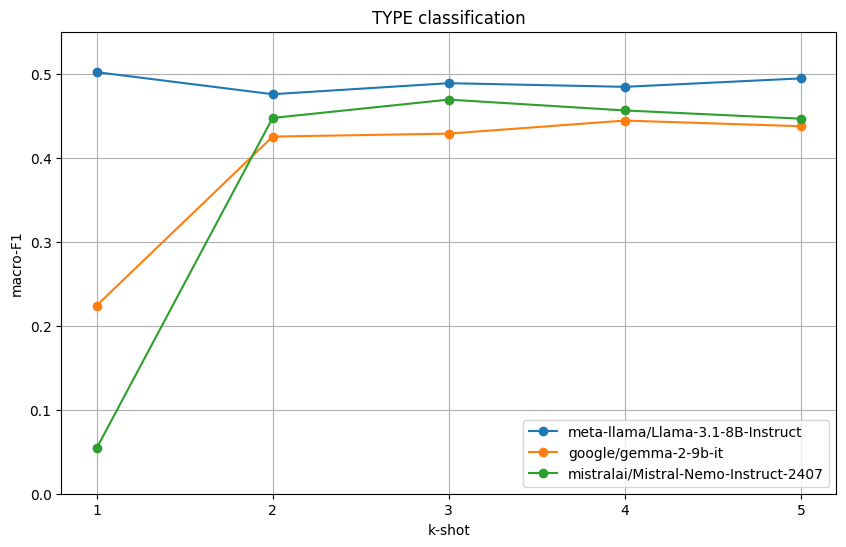

In [11]:
import matplotlib.pyplot as plt

# データをロード
data = show_types

# f1スコアを取得
f1_scores = [entry['f1'] for entry in data]

# 5個ずつに分割
chunk_size = 5
chunks = [f1_scores[i:i + chunk_size] for i in range(0, len(f1_scores), chunk_size)]

# 図示
plt.figure(figsize=(10, 6))
for i, chunk in enumerate(chunks):
    plt.plot(chunk, label=model_names[i], marker='o')

# グラフの装飾
plt.title("TYPE classification")
plt.xlabel("k-shot")
plt.xticks(range(5), range(1, 6))
plt.ylabel("macro-F1")
plt.ylim(0.0, 0.55)
plt.legend()
plt.grid()
plt.show()

In [12]:
# 299 * 3 (seeds)

In [13]:
model_name = model_names[0]
icl_method = "random"
k = 1
golds = []
preds = []
for seed in [111, 5374, 93279]:
    # print(seed)
    # create gold answer
    train_df, eval_df = train_test_split(csv_dataset, test_size = 0.1, random_state=int(seed))
    gold_types, gold_funcs = [], []
    for i, row in eval_df.iterrows():
        gold_types.append(row['type'])
        gold_funcs.append(row['function'].split("（")[0])
    golds += gold_types

    # create pred answer
    pred_data_path = f"/data/group1/z40436a/ME/URL_Citation_Classification_Intermediate/result/output/{model_name}/{icl_method}/{str(seed)}_{str(k)}shot.json"
    with open(pred_data_path, 'r') as json_file:
        LLM_responses = json.load(json_file)

    pred_types, pred_funcs = pred_type_and_func(LLM_responses)

    pred_types = [pred if pred in list(set(gold_types)) else "FormatError" for pred in pred_types]
    preds += pred_types
    pred_funcs = [pred if pred in list(set(gold_funcs)) else "FormatError" for pred in pred_funcs]

    metrics_types_seeds.append(evaluation_metrics(gold_types, pred_types, "type"))
    metrics_funcs_seeds.append(evaluation_metrics(gold_funcs, pred_funcs, "func"))


print("TYPE:", end="")
round_print(ave_metrics_seed(metrics_types_seeds))
show_types.append(ave_metrics_seed(metrics_types_seeds))
print("FUNC:", end="")
round_print(ave_metrics_seed(metrics_funcs_seeds))
show_funcs.append(ave_metrics_seed(metrics_funcs_seeds))

TYPE:{'acc': 0.527, 'pre': 0.519, 'rec': 0.437, 'f1': 0.474, 'err': 0.007}
FUNC:{'acc': 0.484, 'pre': 0.297, 'rec': 0.261, 'f1': 0.277, 'err': 0.039}


In [14]:
print(len(golds))

897


In [15]:
if len(golds) == len(preds) == (len(eval_df)*3):
    print("OK")

OK


In [16]:
import collections
collections.Counter(zip(golds, preds))

Counter({('Tool', 'Tool'): 110,
         ('Code', 'Code'): 108,
         ('Dataset', 'Dataset'): 56,
         ('Paper', 'Paper'): 56,
         ('Website', 'Website'): 47,
         ('Tool', 'Code'): 44,
         ('Document', 'Document'): 32,
         ('DataSource', 'DataSource'): 27,
         ('Mixed', 'Mixed'): 25,
         ('Dataset', 'DataSource'): 23,
         ('DataSource', 'Dataset'): 22,
         ('Code', 'Tool'): 21,
         ('Mixed', 'Code'): 19,
         ('Website', 'DataSource'): 19,
         ('Paper', 'Document'): 18,
         ('Knowledge', 'Code'): 16,
         ('Website', 'Tool'): 14,
         ('Tool', 'Website'): 13,
         ('Knowledge', 'DataSource'): 13,
         ('Knowledge', 'Knowledge'): 12,
         ('Knowledge', 'Tool'): 11,
         ('Knowledge', 'Dataset'): 11,
         ('Website', 'Dataset'): 10,
         ('DataSource', 'Website'): 10,
         ('Document', 'Code'): 9,
         ('Dataset', 'Website'): 9,
         ('Document', 'DataSource'): 8,
         ('Code

In [17]:
model_name = model_names[0]
icl_method = "random"
k = 5
golds = []
preds = []
for seed in [111, 5374, 93279]:
    # print(seed)
    # create gold answer
    train_df, eval_df = train_test_split(csv_dataset, test_size = 0.1, random_state=int(seed))
    gold_types, gold_funcs = [], []
    for i, row in eval_df.iterrows():
        gold_types.append(row['type'])
        gold_funcs.append(row['function'].split("（")[0])
    golds += gold_types

    # create pred answer
    pred_data_path = f"/data/group1/z40436a/ME/URL_Citation_Classification_Intermediate/result/output/{model_name}/{icl_method}/{str(seed)}_{str(k)}shot.json"
    with open(pred_data_path, 'r') as json_file:
        LLM_responses = json.load(json_file)

    pred_types, pred_funcs = pred_type_and_func(LLM_responses)

    pred_types = [pred if pred in list(set(gold_types)) else "FormatError" for pred in pred_types]
    preds += pred_types
    pred_funcs = [pred if pred in list(set(gold_funcs)) else "FormatError" for pred in pred_funcs]

    metrics_types_seeds.append(evaluation_metrics(gold_types, pred_types, "type"))
    metrics_funcs_seeds.append(evaluation_metrics(gold_funcs, pred_funcs, "func"))


print("TYPE:", end="")
round_print(ave_metrics_seed(metrics_types_seeds))
show_types.append(ave_metrics_seed(metrics_types_seeds))
print("FUNC:", end="")
round_print(ave_metrics_seed(metrics_funcs_seeds))
show_funcs.append(ave_metrics_seed(metrics_funcs_seeds))

TYPE:{'acc': 0.527, 'pre': 0.525, 'rec': 0.444, 'f1': 0.481, 'err': 0.005}
FUNC:{'acc': 0.521, 'pre': 0.355, 'rec': 0.306, 'f1': 0.328, 'err': 0.026}


In [18]:
collections.Counter(zip(golds, preds))

Counter({('Tool', 'Tool'): 118,
         ('Code', 'Code'): 96,
         ('Paper', 'Paper'): 65,
         ('Dataset', 'Dataset'): 57,
         ('Website', 'Website'): 46,
         ('Tool', 'Code'): 43,
         ('DataSource', 'DataSource'): 31,
         ('Document', 'Document'): 28,
         ('Dataset', 'DataSource'): 26,
         ('Mixed', 'Code'): 25,
         ('Code', 'Tool'): 25,
         ('Website', 'DataSource'): 23,
         ('DataSource', 'Dataset'): 21,
         ('Website', 'Tool'): 17,
         ('Knowledge', 'Code'): 15,
         ('Knowledge', 'Knowledge'): 15,
         ('Knowledge', 'Dataset'): 15,
         ('Mixed', 'Mixed'): 14,
         ('Knowledge', 'Tool'): 11,
         ('Tool', 'Website'): 10,
         ('Document', 'Knowledge'): 10,
         ('DataSource', 'Website'): 9,
         ('Document', 'DataSource'): 9,
         ('Paper', 'Document'): 9,
         ('Website', 'Dataset'): 9,
         ('Code', 'Website'): 8,
         ('Mixed', 'Dataset'): 6,
         ('Document', 'C